# Tutorial for Functions.py

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

In [2]:
import jax.numpy as jnp

In [3]:
from IPython.display import clear_output

In [4]:
import sys
sys.path.append('../')

In [5]:
from MDRefine import load_data, minimizer, select_traintest, hyper_minimizer, MDRefinement

a simple script to unwrap dictionaries:

In [6]:
def unwrap_dict(d):

    res = []
    
    if isinstance(d, dict):
        for val in d.values():
            res.extend(unwrap_dict(val))
    else:
        if isinstance(d, list): res = d
        else: res = [d]

    return np.hstack(res)

## 4. Ensemble + forward-model refinement

### a. Load data

In [7]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = '../../DATA'
infos['global']['system_names'] = ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs', '<')]
infos['global']['forward_qs'] = ['backbone1_gamma', 'backbone2_beta_epsilon','sugar']
infos['global']['obs'] = ['NOEs', 'uNOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 100

In [8]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],#}
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8]}

    return forward_qs_out

In [9]:
infos['global']['forward_model'] = forward_model_fun

In [12]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


Regularization:

\begin{equation}
\begin{split}
R(A,B,C) & = \frac{1}{2\pi}\int_0^{2\pi} d\gamma(^3J(\gamma)-^3J_0(\gamma))^2 \\
& = \frac{1}{2\pi} \int_0^{2\pi} d\gamma [(A-A_0)\cos^2\gamma+(B-B_0)\cos\gamma+(C-C_0)]^2 \\
& = \frac{3}{8}(A-A_0)^2 + \frac{1}{2}(B-B_0)^2 + (C-C_0)^2 + (A-A_0)(C-C_0)
\end{split}
\end{equation}

which is 1/2 of the regularization proposed in *Simultaneous refinement of molecular dynamics ensembles
and forward models using experimental data* by Thorben Frohlking et al.

In [13]:
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [14]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### b. Minimize

let's use optimal hyperparameters determined by Thorben

In [15]:
opt_alpha = 174.33288
opt_gamma = 3.43332*2

In [16]:
Result = minimizer(data, regularization=regularization, alpha=opt_alpha, gamma=opt_gamma)

New evaluation:
loss:  862.3952567082285
gradient:  [ 0.26033995  0.5460536   1.09553194 -5.75676771 -5.9178891  -3.85918001
 14.93975622 -5.24698836 23.26844199] 

New evaluation:
loss:  858.6235183866291
gradient:  [-3.21194878e-01 -1.47523366e-02 -3.97834150e-01 -5.15551258e-01
  8.74376479e-02  6.79424813e+00 -9.55170262e+00  9.82742039e-01
 -2.08486285e+01] 

New evaluation:
loss:  855.2858205580916
gradient:  [ -1.03996345  -1.00291554  -2.42545676   1.22842216   5.90707641
   6.94843838  -6.31344921   7.72428996 -13.30731092] 

New evaluation:
loss:  854.6075952291478
gradient:  [  1.56816055   0.95144096   3.86784888  -4.84106546   0.73980004
 -10.41341422  -7.10682521   3.10378109 -12.295159  ] 

New evaluation:
loss:  853.5001415969107
gradient:  [  1.51089684   0.90196717   3.69286915  -3.421373     1.55990671
  -8.32438662  -6.38028711   0.96415354 -10.48712414] 

New evaluation:
loss:  852.2866266775504
gradient:  [-0.42506979 -0.53522639 -1.13040562 -3.25443074 -1.8603250

In [16]:
from MDRefine import save_txt

In [22]:
input_values = {'stride': stride, 'alpha': opt_alpha, 'beta': np.inf, 'gamma': opt_gamma}

coeff_names = vars(data['global'])['forward_coeffs_0'].index

save_txt(input_values, Result, coeff_names, folder_name='my_result_Karplus')

In [23]:
Result.D_KL_alpha

{'AAAA': DeviceArray(0.12610046, dtype=float64),
 'CAAU': DeviceArray(1.00394874, dtype=float64),
 'CCCC': DeviceArray(0.57323848, dtype=float64),
 'GACC': DeviceArray(0.01993576, dtype=float64),
 'UUUU': DeviceArray(0.22234128, dtype=float64),
 'UCAAUC': DeviceArray(1.22260811, dtype=float64)}

In [24]:
Result.pars

array([ 9.77179171, -1.82234482, -0.05542348, 16.82491049, -5.69502992,
        0.88638209,  8.74040589, -1.81909928, -0.07139431])

In [26]:
Result.loss

DeviceArray(263.61361, dtype=float64)

In [41]:
tot_chi2 = np.sum([item2 for item in Result.chi2.values() for item2 in item.values()])
print(1/2*tot_chi2)

print(opt_gamma*Result.reg_fm)
print(opt_alpha*np.sum([l for l in Result.D_KL_alpha.values()]))

opt_gamma*Result.reg_fm + opt_alpha*np.sum([l for l in Result.D_KL_alpha.values()]) + 1/2*tot_chi2

233.6011421874418
5.7006969504339295
24.312208860206894


263.61404799808264

In [18]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

In [17]:
vars(Result.intermediates).keys()

dict_keys(['loss', 'pars', 'lambdas', 'minis'])

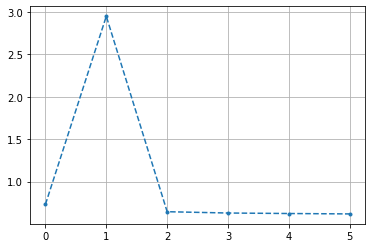

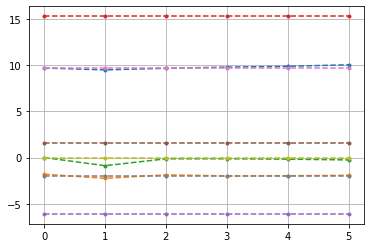

In [19]:
plt.plot(Result.intermediates.loss, '.--')
plt.grid()

plt.figure()
inter_pars = Result.intermediates.pars
for i in range(inter_pars.shape[1]):
    plt.plot(Result.intermediates.pars[:,i], '.--')
plt.grid()

### c. Search for optimal hyper-parameters

In [20]:
hyper_minimizer(data, regularization=regularization, starting_alpha=100, starting_gamma=100, random_states=[0])


Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 2.0), ('gamma', 2.0)]
New evaluation:
loss:  0.9832437889023238
gradient:  [0.60041219 0.94583931 1.94371647 0.         0.         0.
 0.         0.         0.        ] 

New evaluation:
loss:  114.24234211043903
gradient:  [-109.04744803  -44.39894468 -206.15806388    0.            0.
    0.            0.            0.            0.        ] 

New evaluation:
loss:  0.9721387417430688
gradient:  [-0.47486385  0.50100449 -0.09722966  0.          0.          0.
  0.          0.          0.        ] 

New evaluation:
loss:  0.995011123257862
gradient:  [ 0.5337481  -2.26056719  0.93511279  0.          0.          0.
  0.          0.          0.        ] 

New evaluation:
loss:  0.9693608649713116
gradient:  [-0.22518974 -0.18266286  0.15823101  0.          0.          0.
  0.          0.          0.        ] 

New evaluation:
loss:  0.9675535908722475
gradient:  [ 0.08120164  0.06619401 -0.0539217

          fun: DeviceArray(1.96080746, dtype=float64)
     hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.Functions.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7f6f54415f28>
          jac: array([0.12355655, 0.15406057])
      message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
         nfev: 1
          nit: 0
         njev: 1
       status: 0
      success: True
            x: array([2., 2.])

## 5. Fully combined refinement

### a. Load data

In [16]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = '../../DATA'
infos['global']['system_names'] = ['AAAA','CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs', '<')]
infos['global']['forward_qs'] = ['backbone1_gamma', 'backbone2_beta_epsilon','sugar']
infos['global']['obs'] = ['NOEs', 'uNOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 100

In [17]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [18]:
infos['global']['forward_model'] = forward_model_fun

In [19]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha', 'sin zeta', 'cos zeta']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10,5,15]]+f[:,[1,11,6,16]]+f[:,[2,12,7,17]]+f[:,[3,13,8,18]]+f[:,[4,14,9,19]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [20]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [21]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


In [12]:
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [13]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### b. Minimize

sin,cos: 0.5670107992298928,-0.7708171840600693,

gamma: 10.073939647568015,-1.7274624854944427,-0.18103683805065413,

beta: 18.139363745072547,-5.287610829632396,0.06806038237686833,

sugar: 7.0217099769604605,-1.6419076545887323,0.648997186035425

av. chi2:  1196.4939308128344
av. gradient:  [-0.08977391 -0.90069121 -0.29263519]

log10 hyperpars:  [('alpha', 2.9822059969013717), ('beta', 2.225141867809032), ('gamma', -0.3749357545683457)]


In [ ]:
alpha = 10**1.0453604032996766
beta = 10**-1.3792677078120605
gamma = 10**-0.013915384118032064

In [22]:
alpha = 10**2.9822059969013717
beta = 10**2.225141867809032
gamma = 10**-0.3749357545683457

In [ ]:
Result = minimizer(data, regularization=regularization, alpha=alpha, beta=beta, gamma=gamma)

In [30]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'weights_P', 'logZ_P', 'reg_ff', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

In [31]:
Result.pars

array([ 0.584369  , -0.79189575,  9.93293172, -1.75313237, -0.12452308,
       18.11038972, -5.30036147,  0.08335626,  6.98232334, -1.63483294,
        0.66851206])

In [60]:
Result.mini

      fun: 2.282926673913012
 hess_inv: array([[ 5.37846378e-01, -5.94041901e-03, -4.42145688e-01,
        -1.97232898e-02,  1.63245143e-02, -5.57596041e-03,
        -3.18368396e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.94041901e-03,  9.98539836e-01, -1.45645109e-03,
        -1.93951817e-02,  3.69293674e-02,  1.24948465e-02,
        -5.56885853e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-4.42145688e-01, -1.45645109e-03,  5.77666109e-01,
        -3.13187555e-02,  2.83026623e-02,  1.90902714e-02,
        -3.40369824e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.97232898e-02, -1.93951817e-02, -3.13187555e-02,
         1.10665744e+00, -2.77246136e-01, -1.39975049e-01,
         2.38985340e-01,  0.00000000e+00,  0.00000000e+0

In [19]:
Result.minis

{'AAAA':       fun: -10.507619992690685
  hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]])
       jac: array([-5.49653570e-05, -5.47391650e-05,  2.11852284e-04,  3.88328320e-05,
         1.16655592e-04, -1.15083849e-06, -2.84512042e-04, -1.31942980e-04,
        -1.18534050e-05, -1.90803831e-04,  1.35917176e-04,  5.12378532e-05,
         1.47919389e-05, -2.40391759e-05,  1.45694660e-04,  1.06335639e-04,
        -1.59983452e-06,  5.44929690e-04, -1.50328426e-04,  1.46868358e-05,
         1.89647116e-04, -1.12882226e-04, -1.61548533e-05, -7.47772014e-04,
        -1.19459748e-04,  2.01931719e-04, -5.55774763e-05,  1.71100412e-04,
        -1.62825692e-05, -6.40423500e-05,  5.29456805e-05, -3.19958137e-05,
         1.17196685e-04,  8.02226254e-05,  1.14117897e-04, -1.19123958e-06,
         1.26342341e-04,  2.92529391e-04, 

In [19]:
vars(Result.intermediates).keys()

dict_keys(['loss', 'pars', 'lambdas', 'minis'])

In [20]:
np.array(Result.intermediates.lambdas).shape

(33, 55)

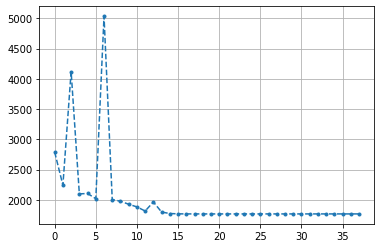

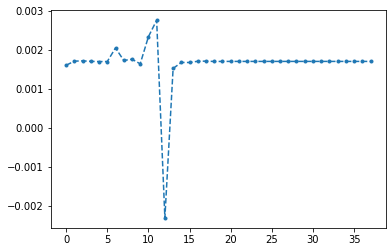

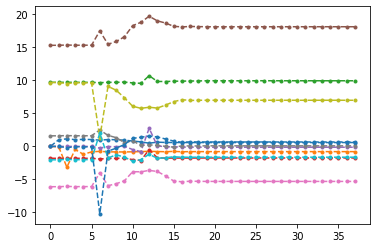

In [28]:
inter_loss = Result.intermediates.loss
plt.plot(inter_loss, '.--')
plt.grid()

plt.figure()

inter_lambdas = np.array(Result.intermediates.lambdas)
plt.plot(inter_lambdas[:,0], '.--')

plt.figure()
plt.plot(Result.intermediates.pars, '.--')
plt.show()

In [22]:
Result.abs_difference

{'AAAA': DeviceArray(0.0003582, dtype=float64),
 'CAAU': DeviceArray(0.00164201, dtype=float64)}

### c. Determine optimal hyper-parameters through cross validation

In [29]:
data_train, data_test, test_obs, test_frames = select_traintest(data, random_state = 1)

Input random_state employed both for test_obs and test_frames


In [32]:
alpha = 1
beta = 1
gamma = 1

In [31]:
Result = minimizer(data_train, regularization=regularization, alpha=alpha, beta=beta, gamma=gamma, data_test=data_test)

New evaluation:
loss:  7.218360190860758
gradient:  [-0.30922389  0.27360061  0.24219019  0.50157626  1.02694667 -0.16473271
  0.0682929   0.78346349  3.34467476 -2.34255479  6.05884959] 

New evaluation:
loss:  4.458379125864339
gradient:  [-2.14031112e-01  1.20403008e-02 -2.19763942e-01 -4.02697246e-02
 -3.39271525e-01 -4.39311365e-01 -2.38448202e-01  1.04582188e-04
 -1.06382128e+00 -6.01514325e-01 -1.97421967e+00] 

New evaluation:
loss:  4.664305148216842
gradient:  [ 1.1454502   0.02582114 -0.01947333 -0.03764017  0.07504489 -0.24898822
 -0.02953331 -0.00997176  0.22198586  1.91434558  0.21367926] 

New evaluation:
loss:  4.075730209339285
gradient:  [ 0.41720335  0.03355911 -0.13174014 -0.03788369 -0.15638763 -0.35173728
 -0.13857755  0.01208964 -0.46413812  0.53364411 -0.98111768] 

New evaluation:
loss:  4.138403006684695
gradient:  [-1.82331466e+00  1.24389295e-01  5.22437816e-02  2.80241230e-02
  2.52176161e-01 -1.52266049e-05  2.31727150e-01  4.53736176e-01
  3.45508978e-01 

In [22]:
delta = 2.0

log10_alphas = np.arange(-2,2+delta,delta)
log10_betas = np.array([-2.0,0.0,2.0])
log10_gammas = log10_alphas

Results = {}

for log10_alpha in log10_alphas:
    Results[log10_alpha] = {}
    for log10_beta in log10_betas:
        Results[log10_alpha][log10_beta] = {}
        for log10_gamma in log10_gammas:
            print(log10_alpha, log10_beta, log10_gamma)
            Results[log10_alpha][log10_beta][log10_gamma] = minimizer(data_train, regularization = regularization, alpha = 10**log10_alpha, beta = 10**log10_beta, gamma = 10**log10_gamma, data_test = data_test)

            clear_output()

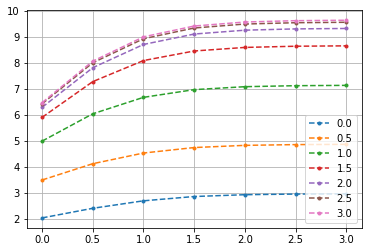

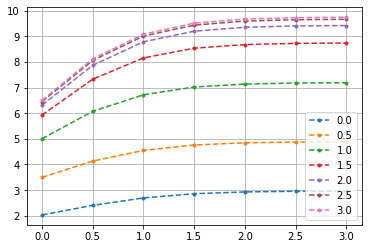

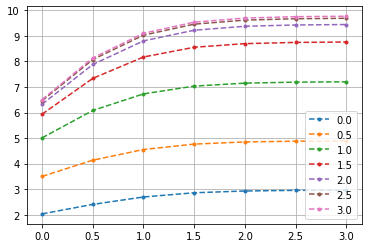

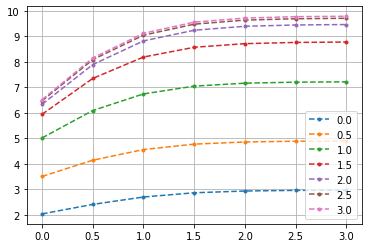

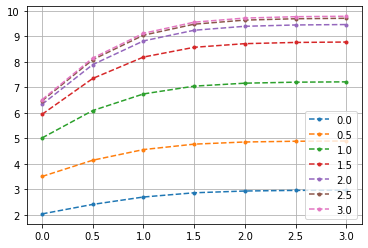

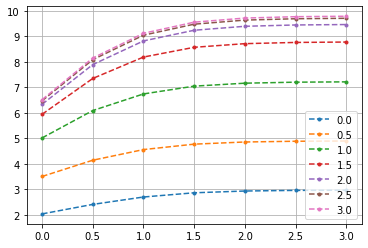

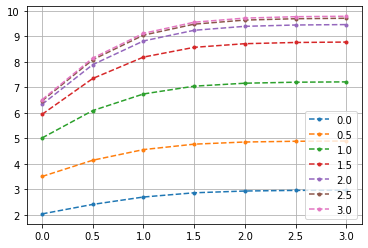

In [127]:
for log10_beta in log10_betas:

    plt.figure()

    for log10_gamma in log10_gammas:
        loss = np.array([Results[log10_alpha][log10_beta][log10_gamma].loss for log10_alpha in log10_alphas])
        plt.plot(log10_alphas, loss, '.--', label = log10_gamma)

    plt.legend()
    plt.grid()

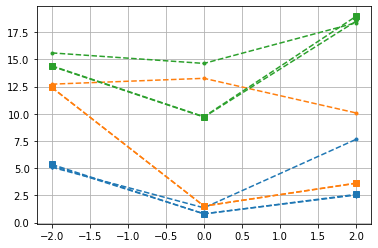

In [28]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink', 'tab:gray','tab:olive','tab:cyan']
markers = ['.','v','s','*','D','o','^','<','>','p','P','+','X','d']

for i,log10_beta in enumerate(log10_betas):

    # plt.figure()

    for j,log10_gamma in enumerate(log10_gammas):
        chi2 = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2)) for log10_alpha in log10_alphas])
        chi2_test = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2_test)) for log10_alpha in log10_alphas])
        chi2_new_obs = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2_new_obs)) for log10_alpha in log10_alphas])

        loss = np.array([Results[log10_alpha][log10_beta][log10_gamma].loss for log10_alpha in log10_alphas])
        
        # plt.plot(log10_alphas, loss, markers[i] + '--', color = colors[j], label = log10_gamma)
        # plt.plot(log10_alphas, chi2, markers[i] + '--', color = colors[j], label = log10_gamma)
        plt.plot(log10_alphas, chi2_test, markers[i] + '--', color = colors[j], label = log10_gamma)
        # plt.plot(log10_alphas, chi2_new_obs, markers[i] + '--', color = colors[j], label = log10_gamma)

    # plt.legend()
    plt.grid()

### d. automatic optimization of hyper parameters

In [23]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=1, starting_beta=1, starting_gamma=1, random_states=2, which_set='test')


Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 0.0), ('beta', 0.0), ('gamma', 0.0)]
av. chi2:  5.972398215962857
av. gradient:  [-1.46608349  0.99024154  0.37872832]

log10 hyperpars:  [('alpha', 0.8103230992679074), ('beta', -0.5473191660109289), ('gamma', -0.20932798501383995)]
av. chi2:  5.405594656718937
av. gradient:  [ 0.78425728  0.69104817 -0.31317981]

log10 hyperpars:  [('alpha', 0.6523764812692163), ('beta', -0.8327816618170336), ('gamma', -0.13300288872260302)]
av. chi2:  5.268445096930829
av. gradient:  [ 1.46107493 -0.50118545  0.03884097]


In [41]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=10**1.3, starting_beta=10**-2.2, starting_gamma=10**-3.5, random_states=2)


Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 1.2999999999999998), ('beta', -2.1999999999999997), ('gamma', -3.5)]
av. chi2:  53.37941152691285
av. gradient:  [ 6.92611317  0.00920734 -0.02969662]

log10 hyperpars:  [('alpha', 0.30001007534433244), ('beta', -2.201329353359527), ('gamma', -3.4957124124734205)]
av. chi2:  1470.193965714341
av. gradient:  [-4221.1437801     22.10937855  -797.67416422]

log10 hyperpars:  [('alpha', 1.2831924954091514), ('beta', -2.20002234333781), ('gamma', -3.4999279356268898)]
av. chi2:  53.33184871668732
av. gradient:  [ 0.40239291  0.01243141 -0.0792381 ]


In [19]:
alpha, beta, gamma = 10**hyper_out.x

Result = minimizer(data, regularization=regularization, alpha=alpha, beta=beta, gamma=gamma)

New evaluation:
loss:  16.25450640268261
gradient:  [-3.63029057  0.51410433  0.18019157  0.39633043  0.77638685 -1.58448253
 -1.530409   -0.89155623  5.92114195 -3.92512424 10.24294161] 

New evaluation:
loss:  10.430561282733445
gradient:  [ 0.47773241  0.10908383 -0.15053235  0.00914026 -0.15144131 -0.84476704
 -0.63554135  0.68028354 -0.90998577 -1.39043733 -2.2510946 ] 

New evaluation:
loss:  15.372609022396441
gradient:  [ 0.36362585  0.34057541  0.01551185 -0.07350584  0.08856049  0.76701551
  2.05284735  2.75974316  1.6441828   7.28688095  2.29288018] 

New evaluation:
loss:  9.730756176514886
gradient:  [ 0.51604069  0.17922759 -0.10692305 -0.01307261 -0.08689658 -0.41266757
  0.07678425  1.23504366 -0.17919436  0.87989882 -1.04323101] 

New evaluation:
loss:  9.772361232581739
gradient:  [-0.62878806  0.29539541  0.07560361  0.06119044  0.31498925 -2.01436563
 -1.27551513 -3.48667892 -0.14960368  0.98460133 -0.64180897] 

New evaluation:
loss:  9.388990896572206
gradient:  [

In [ ]:
out = MDRefinement(infos, regularization=regularization, stride=stride, starting_alpha=10**1.3, starting_beta=10**-2.2, starting_gamma=10**-3.5, random_states=2, results_folder_name='../../my_results')

In [39]:
vars(hyper_out.intermediate)

{'av_chi2': DeviceArray([3220.8482193 ,  784.77228446,  118.72340449,  112.93914809,
                80.42440237, 4249.3130833 ,   79.47914872,   78.58760401,
               719.89355069,   59.35159336,   62.45606527,   53.4564206 ,
               344.31401893,   53.3878092 ], dtype=float64),
 'av_gradient': DeviceArray([[-4.71907912e+02,  3.80431317e+02,  6.05791265e+02],
              [-3.38118970e+03,  2.77511807e+02,  5.49479146e+02],
              [ 3.06923194e+01, -7.73593279e-03, -2.24235717e-01],
              [ 3.69517114e+01, -7.74003580e-03, -2.03937041e-01],
              [ 5.48671762e+01, -9.46846022e-03, -5.87234304e-02],
              [-2.34071194e+02,  6.64293804e-01, -3.45449127e+02],
              [ 5.49605293e+01, -9.45578801e-03, -5.11679816e-02],
              [ 5.50270904e+01, -9.57573442e-03, -4.93249063e-02],
              [-2.81928285e+03,  6.27113241e+00, -3.47205417e+02],
              [ 4.46075677e+01, -6.81958476e-03,  4.20396703e-02],
              [-1.283

if you do not specify some hyper parameters, as for example $\gamma$, you are fixing it to $+\infty$ (no refinement in that "direction")

In [53]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=0.1, starting_beta=10, random_states=2, gtol=0.1)


Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', -0.9999999999999998), ('beta', 1.0)]
tot chi2:  28.050535978184612
tot gradient:  [-23.41717915  -0.09195889]

log10 hyperpars:  [('alpha', 0.009992212381299215), ('beta', 1.0039662235349724)]
tot chi2:  23.218529704974383
tot gradient:  [21.17701877  0.04725389]

log10 hyperpars:  [('alpha', -0.46963406750226966), ('beta', 1.0020827386764306)]
tot chi2:  17.14549663562447
tot gradient:  [-3.79427275 -0.11473703]

log10 hyperpars:  [('alpha', -0.3669318992980608), ('beta', 1.1216298262759157)]
tot chi2:  17.227550737324293
tot gradient:  [ 5.8158668  -0.02828849]

log10 hyperpars:  [('alpha', -0.42653134673513593), ('beta', 1.0522550458966544)]
tot chi2:  17.073776208659613
tot gradient:  [ 0.31939131 -0.07235223]

log10 hyperpars:  [('alpha', -0.4297529259557293), ('beta', 1.1257705063949672)]
tot chi2:  17.06863761890843
tot gradien

In [56]:
vars(hyper_out.intermediate)

{'tot_chi2': DeviceArray([28.05053598, 23.2185297 , 17.14549664, 17.22755074,
              17.07377621, 17.06863762], dtype=float64),
 'tot_gradient': DeviceArray([[-23.41717915,  -0.09195889],
              [ 21.17701877,   0.04725389],
              [ -3.79427275,  -0.11473703],
              [  5.8158668 ,  -0.02828849],
              [  0.31939131,  -0.07235223],
              [  0.06255257,  -0.06224764]], dtype=float64),
 'log10_hyperpars': DeviceArray([[-1.        ,  1.        ],
              [ 0.00999221,  1.00396622],
              [-0.46963407,  1.00208274],
              [-0.3669319 ,  1.12162983],
              [-0.42653135,  1.05225505],
              [-0.42975293,  1.12577051]], dtype=float64)}